In [1]:
import pandas as pd
import sys, os, subprocess, shutil, glob, bz2, csv
from Bio import SeqIO
import numpy as np
import json

import collections
import logomaker as lm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
#sns.set_theme(style="ticks", palette="pastel")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

# Navigate back to workbookDir in case of re-running a code block:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
os.chdir(workbookDir)  # If you changed the current working dir, this will take you back to the workbook dir.

workbookDir: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/4-plotting


### Requirements
1. gfsa
2. hgrewsa

In [2]:
def freq2ratio(freq):
    return(freq / (1 - freq))

def ratio2freq(ratio):
    return(ratio / (ratio + 1))

In [3]:
#### Comments ######

# Parse all data and for each sample generate the following dataframe:
# readID, sample_name, replicate, barcode, tRNA_annotation, align_score, unique_annotation, tRNA_annotation_len, align_5p_idx, align_3p_idx, align_5p_nt, align_3p_nt, codon, anticodon, amino_acid, 5p_cover, 3p_cover, 5p_non-temp, 3p_non-temp

# readID -> (string) fastq raw data read header/ID
# sample_name -> (string) non unique sample name
# replicate -> (integer) replicate number (sample_name - replicate should be unique)
# barcode -> (string) barcode name
# tRNA_annotation -> (string) tRNA annotation string, either unique or multiple separated by @
# align_score -> (integer) alignment score
# unique_annotation -> (True/False) if annotation is unique or (multiple or centroid)
# tRNA_annotation_len -> (integer) the length of the tRNA annotated, if multiple annotations take the first
# align_5p_idx -> (integer) first base (by index) of annotated tRNA in the alignement
# align_3p_idx -> (integer) last base (by index) of annotated tRNA in the alignement (if CC add one to index)
# align_5p_nt -> (string) first base of annotated tRNA in the alignement
# align_3p_nt -> (string) last base of annotated tRNA in the alignement
# codon -> (string) codon
# anticodon -> (string) anticodon
# amino_acid -> (string) amino acid
# 5p_cover -> (True/False) if align_5p_idx == 1
# 3p_cover -> (True/False) if align_3p_idx == tRNA_annotation_len
# 5p_non-temp -> (string) 5' bases not part of the alignment to the annotation i.e. non-template bases
# 3p_non-temp -> (string) 3' bases not part of the alignment to the annotation i.e. non-template bases







# Stats general:
# Percent covering 3' (read covering end[-1]), percent with 3' truncation
# Percent of those covering 3' are full length


In [4]:
# Variables that changes from batch to batch:
#data_folder = 'data/pilot_exp'
#project_folder = 'projects/pilot_exp'
data_folder = 'data/pilot_exp_v3'
project_folder = 'projects/pilot_exp_v3'
# tRNA_database = '../../../2-align_reads/tRNA_database/hg19_mature-tRNA.fa'

CLEAN_DIR = False  # Delete old stats_collection dir
OVERWRITE = False   # Overwrite old stat file
DRY_RUN = False     # Do dry-run, print files to run, nothing else
SP_SET = {'mouse', 'human'} # Only run if species is in set


In [5]:
# Variables that should not change:
plots_data_dir = 'plotting'
data_dir = 'stats_collection'
sample_list = 'sample_list.xlsx'
stat_csv_fnam = 'stats_collection.csv.bz2'
#agg_csv_fnam = 'stats_filtered_CC-CCA-aggregate.csv'
agg_csv_fnam = 'stats_strict_filtered_CC-CCA-aggregate.csv'

In [6]:
### Read sample information ###
sample_df = pd.read_excel('../' + project_folder + '/' + sample_list)

# Create folder for plots:
os.chdir('../' + data_folder)
plots_dir = '../../' + project_folder + '/plots'
try:
    os.mkdir(plots_dir) # For plots
except:
    if CLEAN_DIR:
        shutil.rmtree(plots_dir)
        os.mkdir(plots_dir)
    else:
        pass
# For manipulations:
try:
    os.mkdir(plots_data_dir) # For data
except:
    if CLEAN_DIR:
        shutil.rmtree(plots_data_dir)
        os.mkdir(plots_data_dir)
    else:
        pass
os.chdir(plots_data_dir)

In [7]:
%%bash
pwd

/Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/data/pilot_exp_v3/plotting


In [213]:
# Read annotation data:
with bz2.open('../' + data_dir + '/' + stat_csv_fnam, 'rb') as fh:
    # Load from csv:
    df_reads = pd.read_csv(fh)

# Add extra annotations:
df_reads = df_reads.fillna('')
df_reads['mito_codon'] = ['mito_tRNA' in anno for anno in df_reads['tRNA_annotation'].values]
df_reads['human_codon'] = ['Homo_sapiens' in anno for anno in df_reads['tRNA_annotation'].values]
df_reads['barcode_v2'] = ['N' in anno for anno in df_reads['barcode'].values]
df_reads['barcode_v3'] = ['GGCTGCCATGC' in anno for anno in df_reads['barcode'].values]
#df_reads['frac_mix'] = [float(sm.split('p')[0])/100 for sm in df_reads['sample_name'].values]
df_reads['AA_codon'] = [AA + '-' + codon for codon, AA in zip(df_reads['codon'].values, df_reads['amino_acid'].values)]

# Aggregate 
#agg_cols = ['sample_name', 'replicate', 'barcode', 'frac_mix', 'tRNA_annotation', 'tRNA_annotation_len', 'unique_annotation', 'align_3p_nt', 'codon', 'anticodon', 'amino_acid', 'count']
agg_cols = ['sample_name', 'replicate', 'barcode', 'tRNA_annotation', 'tRNA_annotation_len', 'unique_annotation', 'align_3p_nt', 'codon', 'anticodon', 'amino_acid', 'count']
row_mask = (df_reads['3p_cover']) & (df_reads['3p_non-temp'] == '')
agg_df = df_reads.loc[row_mask, agg_cols[0:-1]]
agg_df['count'] = df_reads.loc[row_mask, ['align_3p_nt']]  # dummy for groupby count
agg_df = agg_df.groupby(agg_cols, as_index=False).agg({"count": "count"})

# Extract a dataframe for charge data:
dfcol = agg_df.columns.values
col_mask = (dfcol != 'align_3p_nt') & (dfcol != 'count')
cols_sele = dfcol[col_mask]
df_charge = pd.DataFrame(columns=cols_sele)
df_charge['charge'] = []
df_charge['Ncharge'] = []
# Count A/C endings:
df_dict = dict()
for row in agg_df.iterrows():
    key = tuple(row[1].loc[cols_sele])
    if key in df_dict:
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']
    else:
        df_dict[key] = dict()
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']
# Add 0 count if count is missing,
# then calculate the charge percentage:
for key in df_dict.keys():
    if 'A' not in df_dict[key]:
        df_dict[key]['A'] = 0
    if 'C' not in df_dict[key]:
        df_dict[key]['C'] = 0

    df_dict[key]['charge'] = df_dict[key]['A'] / (df_dict[key]['A'] + df_dict[key]['C']) * 100
    df_dict[key]['Ncharge'] = (df_dict[key]['A'] + df_dict[key]['C'])

# Use a tmp file to write charge
# and total counts for the row (Ncharge),
# then load into dataframe:
try:
    os.remove('tmp_df.csv')
except:
    pass
with open('tmp_df.csv', 'a') as fh_csv:
    df_charge.to_csv(fh_csv, header=True, index=False)
    for i, key in enumerate(df_dict.keys()):
        row = list(key)
        row.append(df_dict[key]['charge'])
        row.append(df_dict[key]['Ncharge'])
        # df_charge.loc[i] = row # Too slow
        print(','.join(map(str, row)), file=fh_csv)
df_charge = pd.read_csv('tmp_df.csv')
os.remove('tmp_df.csv')

# Add RPM:
for nam in set(df_charge['sample_name'].values):
    rowm = df_charge['sample_name'] == nam
    df_charge.loc[rowm, 'RPM'] = df_charge.loc[rowm, 'Ncharge'].values / (df_charge.loc[rowm, 'Ncharge'].sum()/1e6)
df_charge['logRPM'] = np.log10(df_charge['RPM'].values)

# Melt:
df_charge_melt = pd.melt(df_charge, id_vars=['sample_name'], value_vars=['charge', 'Ncharge', 'RPM', 'amino_acid', 'tRNA_annotation'])

# Mb memory:
df_reads.memory_usage().sum()/1e6

210.062183

In [138]:
def plot_sample_vs_sample(SN1_ls, SN2_ls, df_charge, df_charge_melt, var='charge', amino_acid='all', transcript='all', min_obs=50, xyrange='percentile'):
    '''
    var = [charge, RPM]
    charge = CCA/(CCA+CC)
    RPM = reads per million i.e. how many reads of a given transcript annotation observed per million reads
    '''

    var1 = '{}_1'.format(var)
    var2 = '{}_2'.format(var)
    
    fig, axes = plt.subplots(ncols=len(SN1_ls), figsize=(6.5*len(SN1_ls), 5))
    try:
        len(axes)
    except:
        axes = [axes]

    ax_i = 0
    for SN1, SN2 in zip(SN1_ls, SN2_ls):
        mask1 = np.array([False]*len(df_charge))
        for SN1_i in SN1.split('+'):
            mask1 = mask1 | (df_charge['sample_name'] == SN1_i)
        #mask1 = (df_charge['sample_name'] == SN1)

        mask2 = np.array([False]*len(df_charge))
        for SN2_i in SN2.split('+'):
            mask2 = mask2 | (df_charge['sample_name'] == SN2_i)
        #mask2 = (df_charge['sample_name'] == SN2)

        m12 = pd.merge(
            df_charge[mask1],
            df_charge[mask2],
            how="inner",
            on='tRNA_annotation',
            left_index=False,
            right_index=False,
            sort=True,
            suffixes=("_1", "_2"),
            copy=True,
            indicator=False,
            validate=None,
        )


        min_mask = (m12['Ncharge_1'] > min_obs) & (m12['Ncharge_2'] > min_obs)
        x_vals = m12[min_mask][var1].values
        y_vals = m12[min_mask][var2].values
        xy_vals = np.array([x_vals, y_vals])
        # xy_min = 0
        # xy_max = max(xy_vals)
        if xyrange == 'percentile':
            xy_min = np.percentile(xy_vals, 3)
            xy_max = np.percentile(xy_vals, 97)
        else:
            xy_min, xy_max = xyrange
            
        

        g1 = sns.regplot(ax=axes[ax_i], data=m12[min_mask], x=var1, y=var2)
        if var == 'charge':
            g1.set_xlabel('% charge (sample={})'.format(SN1))
            g1.set_ylabel('% charge (sample={})'.format(SN2))
            g1.set_title('Charge vs. charge (min obs = {})'.format(min_obs))
            axes[ax_i].set(ylim=[xy_min, xy_max])
            axes[ax_i].set(xlim=[xy_min, xy_max])
            axes[ax_i].plot([xy_min, xy_max], [xy_min, xy_max], c='r')
        elif var == 'RPM':
            g1.set_xlabel('RPM (sample={})'.format(SN1))
            g1.set_ylabel('RPM (sample={})'.format(SN2))
            g1.set_title('RPM vs. RPM (min obs = {})'.format(min_obs))
            axes[ax_i].plot([xy_min, xy_max], [xy_min, xy_max], c='r')
        elif var == 'logRPM':
            g1.set_xlabel('log(RPM) (sample={})'.format(SN1))
            g1.set_ylabel('log(RPM) (sample={})'.format(SN2))
            g1.set_title('RPM vs. RPM (min obs = {})'.format(min_obs))
            axes[ax_i].plot([xy_min, xy_max], [xy_min, xy_max], c='r')
        ax_i += 1
        


In [312]:
mask1 = (df_charge['sample_name'] == '100p1N') & (df_charge['charge'] > 20) & (df_charge['charge'] < 99.5)
np.percentile(df_charge[mask1]['charge'].values, [55, 50, 45])

array([90.36308872, 89.44272446, 87.85114765])

In [313]:
mask2 = (df_charge['sample_name'] == '100p4N') & (df_charge['charge'] > 20) & (df_charge['charge'] < 99.5)
np.percentile(df_charge[mask2]['charge'].values, [55, 50, 45])

array([87.26648352, 86.36363636, 85.66517857])

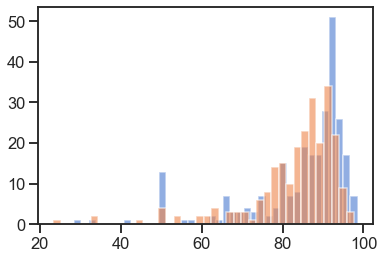

In [314]:
plt.hist(df_charge[mask1]['charge'].values, bins=40, alpha=0.6);
plt.hist(df_charge[mask2]['charge'].values, bins=40, alpha=0.6);

In [132]:
#df_charge

In [133]:
#set(df_charge['sample_name'].values)

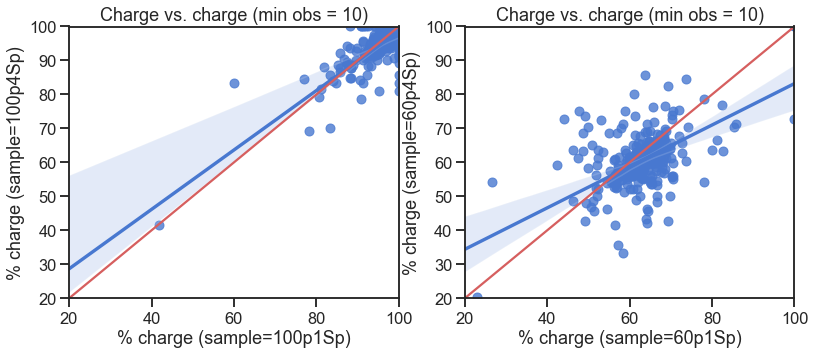

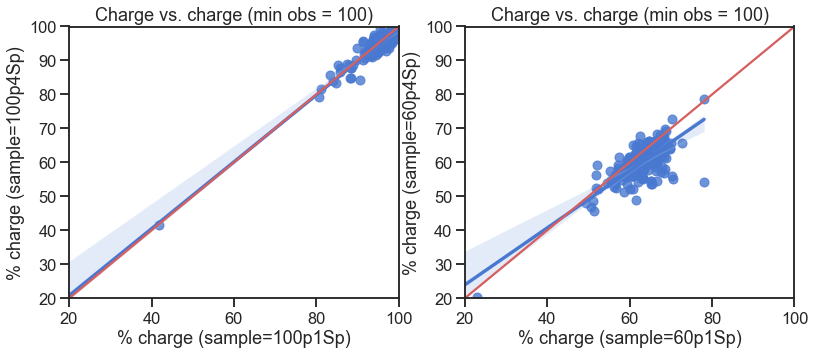

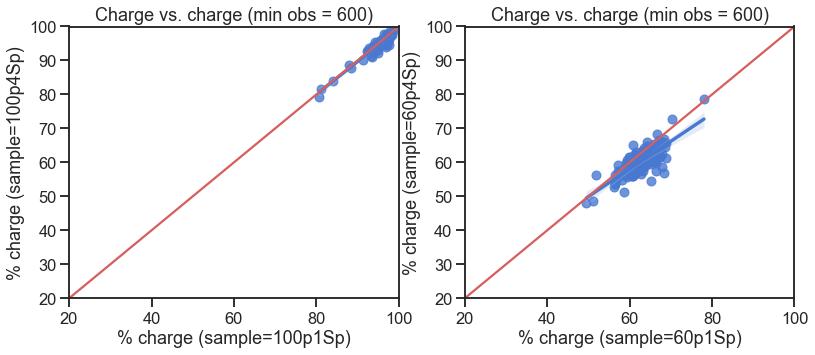

In [318]:
for i in [10, 100, 600]:
    plot_sample_vs_sample(['100p1Sp', '60p1Sp'], ['100p4Sp', '60p4Sp'], df_charge, df_charge_melt, min_obs=i, xyrange=(20, 100))

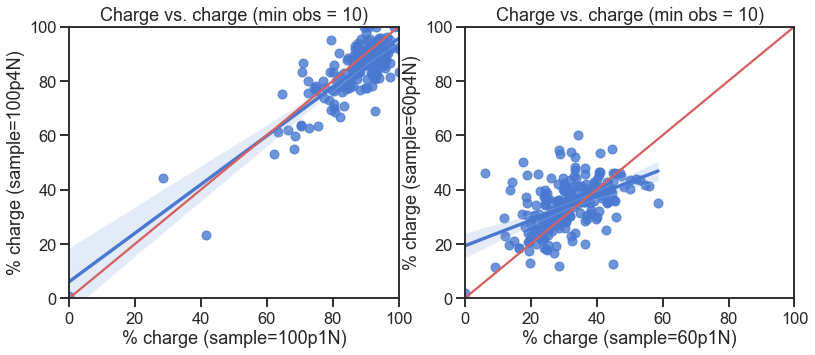

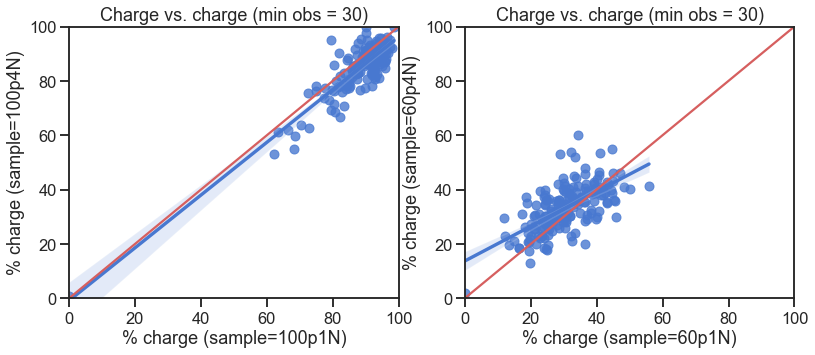

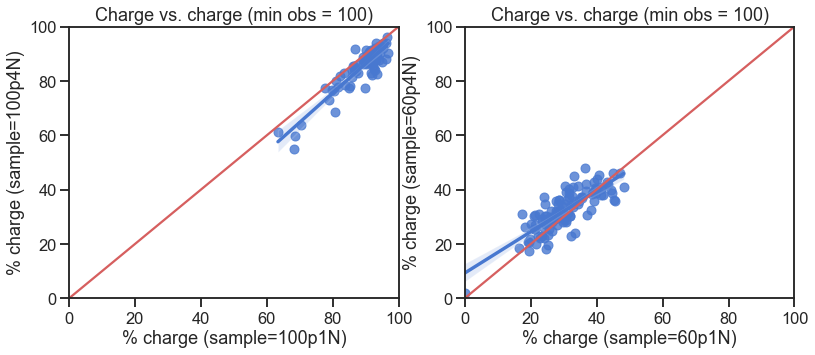

In [320]:
for i in [10, 30, 100]:
    plot_sample_vs_sample(['100p1N', '60p1N'], ['100p4N', '60p4N'], df_charge, df_charge_melt, min_obs=i, xyrange=(0, 100))

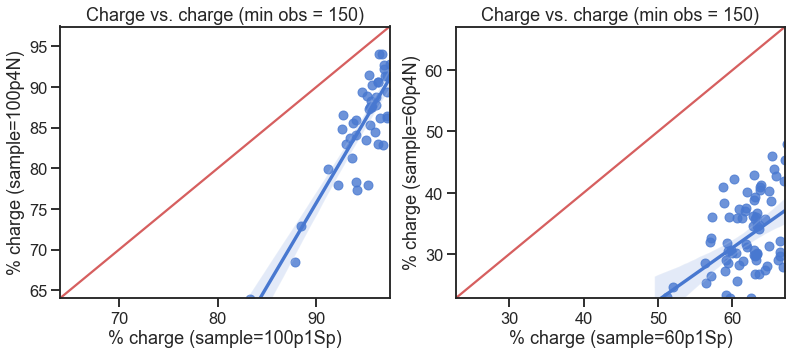

In [136]:
plot_sample_vs_sample(['100p1Sp', '60p1Sp'], ['100p4N', '60p4N'], df_charge, df_charge_melt, min_obs=150)

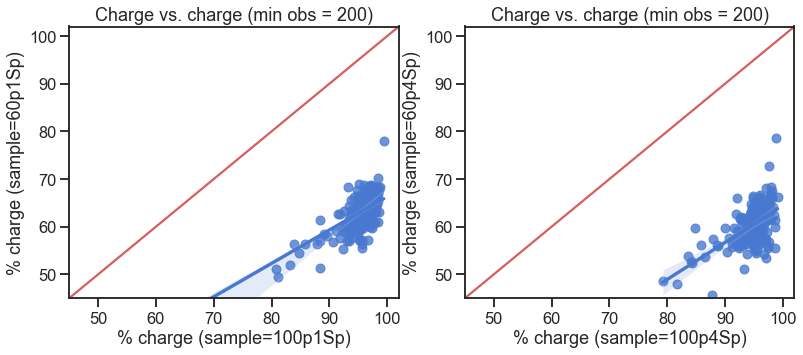

In [123]:
plot_sample_vs_sample(['100p1Sp', '100p4Sp'], ['60p1Sp', '60p4Sp'], df_charge, df_charge_melt, min_obs=200, xyrange=(45, 102))

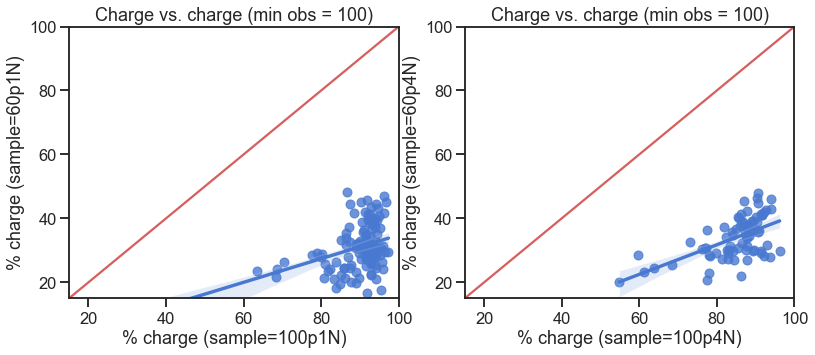

In [137]:
plot_sample_vs_sample(['100p1N', '100p4N'], ['60p1N', '60p4N'], df_charge, df_charge_melt, min_obs=100, xyrange=(15, 100))

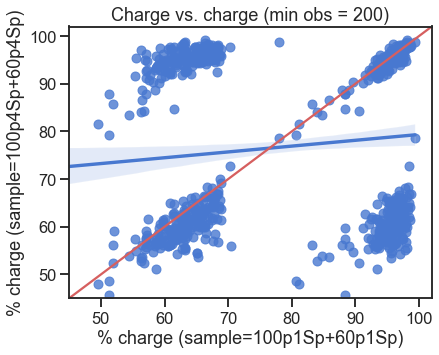

In [329]:
plot_sample_vs_sample(['100p1Sp+60p1Sp'], ['100p4Sp+60p4Sp'], df_charge, df_charge_melt, min_obs=200, xyrange=(45, 102))

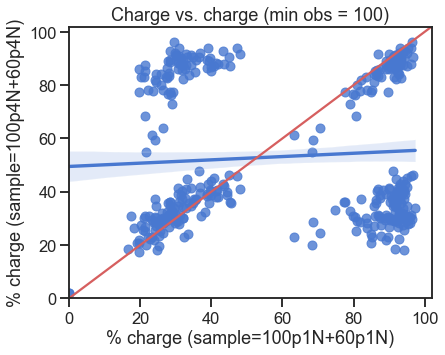

In [332]:
plot_sample_vs_sample(['100p1N+60p1N'], ['100p4N+60p4N'], df_charge, df_charge_melt, min_obs=100, xyrange=(0, 102))

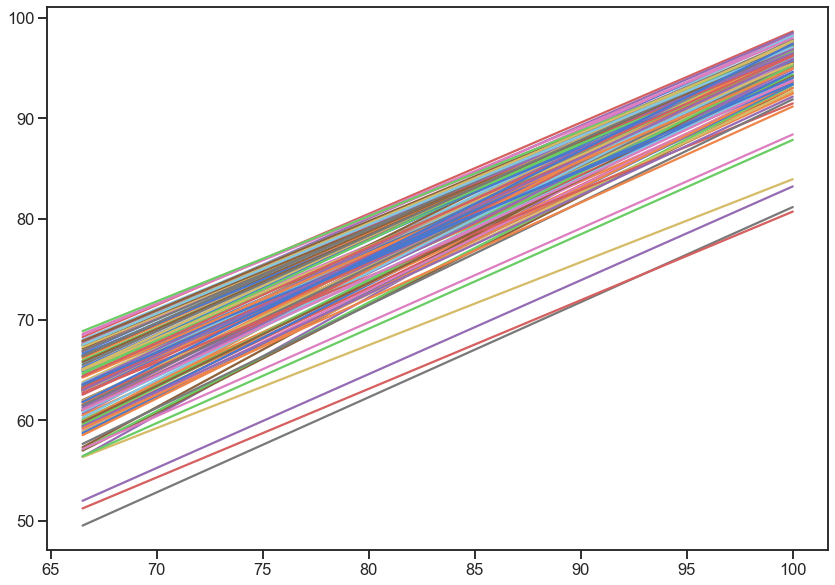

In [250]:

fig, axes = plt.subplots(ncols=1, figsize=(14, 10))

mask1 = (df_charge['sample_name'] == '100p1Sp')
mask2 = (df_charge['sample_name'] == '60p1Sp')

m12 = pd.merge(
    df_charge[mask1],
    df_charge[mask2],
    how="inner",
    on='tRNA_annotation',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_1", "_2"),
    copy=True,
    indicator=False,
    validate=None,
)


min_mask = (m12['Ncharge_1'] > 500) & (m12['Ncharge_2'] > 500)
#x_vals = [el for p100, p60 in zip([100]*len(m12), [60]*len(m12)) for el in (p100, p60)]
#y_vals = [el for p100, p60 in zip(m12[min_mask]['charge_1'].values, m12[min_mask]['charge_2'].values) for el in (p100, p60)]
y_vals = [(p100, p60) for p100, p60 in zip(m12[min_mask]['charge_1'].values, m12[min_mask]['charge_2'].values)]
x_vals = [(p100, p60) for p100, p60 in zip([100]*len(y_vals), [66.5]*len(y_vals))]

slopes = list()
for xv, yv in zip(x_vals, y_vals):
    axes.plot(xv, yv)
    slope = (yv[0] - yv[1]) / (xv[0] - xv[1])
    slopes.append(slope)

slopes = np.array(slopes)

In [251]:
np.percentile(slopes, [90, 50, 10])

array([1.0578385 , 0.96158807, 0.87386887])

In [252]:
np.percentile(slopes, [90, 50, 10])

array([1.0578385 , 0.96158807, 0.87386887])

In [265]:
pmask = (m12[min_mask]['RPM_1'] - m12[min_mask]['RPM_2']) > 0
np.percentile(slopes[pmask], [90, 50, 10])

array([1.03013313, 0.94678614, 0.87307926])

In [192]:
(96 - 96*0.67)/(100-60)

0.7919999999999998

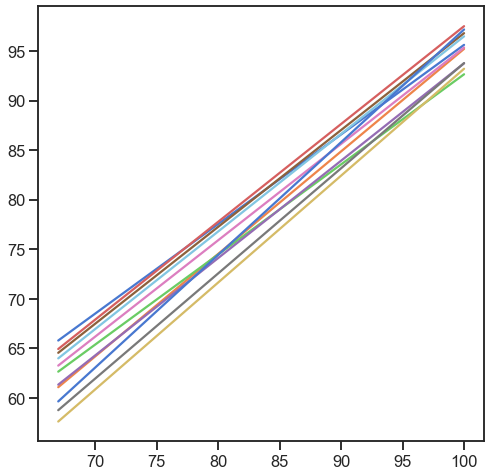

In [475]:
fig, axes = plt.subplots(ncols=1, figsize=(8, 8))

mask1 = (df_charge['sample_name'] == '100p1Sp')
mask2 = (df_charge['sample_name'] == '100p4Sp')
m12 = pd.merge(
    df_charge[mask1],
    df_charge[mask2],
    how="inner",
    on='tRNA_annotation',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_1", "_2"),
    copy=True,
    indicator=False,
    validate=None,
)
m12['Avg_charge'] = (m12['charge_1'] + m12['charge_2'])/2
m12['Ncharge'] = (m12['Ncharge_1'] + m12['Ncharge_2'])/2

mask3 = (df_charge['sample_name'] == '60p1Sp')
mask4 = (df_charge['sample_name'] == '60p4Sp')
m34 = pd.merge(
    df_charge[mask3],
    df_charge[mask4],
    how="inner",
    on='tRNA_annotation',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_1", "_2"),
    copy=True,
    indicator=False,
    validate=None,
)
m34['Avg_charge'] = (m34['charge_1'] + m34['charge_2'])/2
m34['Ncharge'] = (m34['Ncharge_1'] + m34['Ncharge_2'])/2

m1234 = pd.merge(
    m12,
    m34,
    how="inner",
    on='tRNA_annotation',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_1", "_2"),
    copy=True,
    indicator=False,
    validate=None,
)



min_mask = (m1234['Ncharge_1'] > 3500) & (m1234['Ncharge_2'] > 3500)

y_vals = [(p100, p60) for p100, p60 in zip(m1234[min_mask]['Avg_charge_1'].values, m1234[min_mask]['Avg_charge_2'].values)]
x_vals = [(p100, p60) for p100, p60 in zip([100]*len(y_vals), [67]*len(y_vals))]

slopes = list()
for xv, yv in zip(x_vals, y_vals):
    axes.plot(xv, yv)
    slope = (yv[0] - yv[1]) / (xv[0] - xv[1])
    slopes.append(slope)

slopes = np.array(slopes)


In [472]:
np.percentile(slopes, [90, 50, 10])

array([1.07900682, 0.98492567, 0.90957906])

In [473]:
np.percentile(slopes, [90, 50, 10])

array([1.07900682, 0.98492567, 0.90957906])

In [474]:
len(slopes)

11

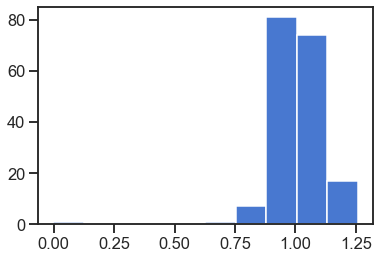

In [454]:
plt.hist(slopes);

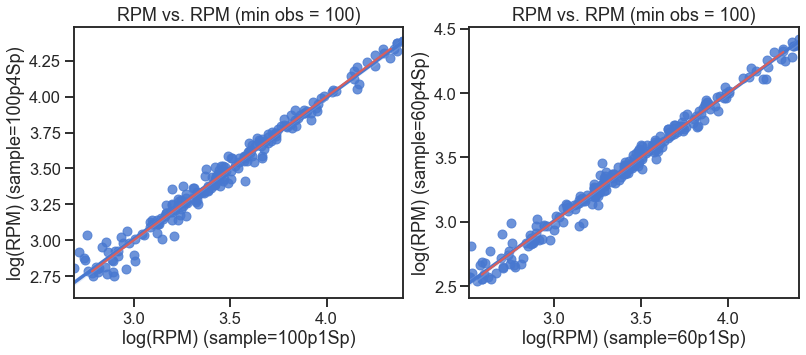

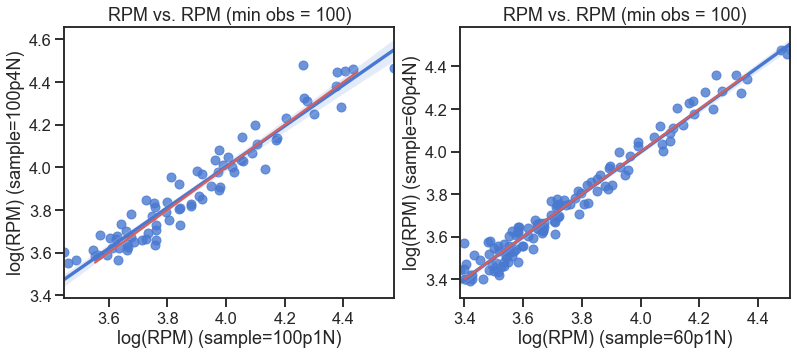

In [323]:
plot_sample_vs_sample(['100p1Sp', '60p1Sp'], ['100p4Sp', '60p4Sp'], df_charge, df_charge_melt, min_obs=100, var='logRPM')
plot_sample_vs_sample(['100p1N', '60p1N'], ['100p4N', '60p4N'], df_charge, df_charge_melt, min_obs=100, var='logRPM')

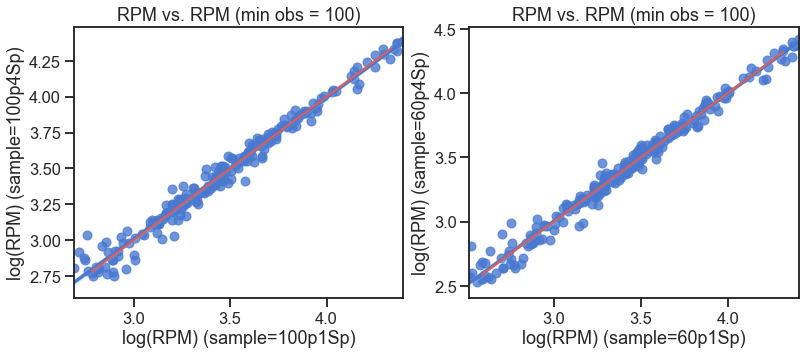

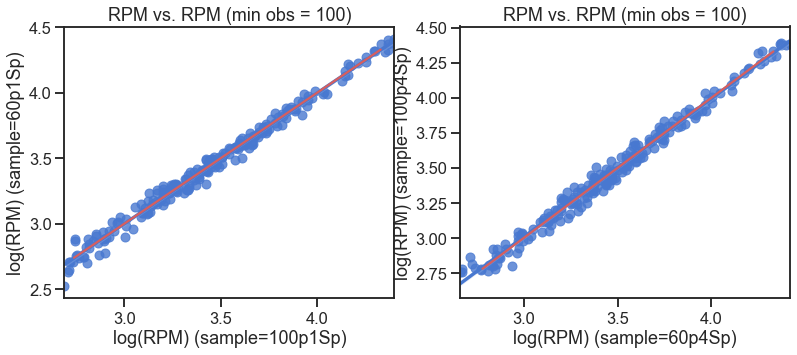

In [229]:
plot_sample_vs_sample(['100p1Sp', '60p1Sp'], ['100p4Sp', '60p4Sp'], df_charge, df_charge_melt, min_obs=100, var='logRPM')
plot_sample_vs_sample(['100p1Sp', '60p4Sp'], ['60p1Sp', '100p4Sp'], df_charge, df_charge_melt, min_obs=100, var='logRPM')

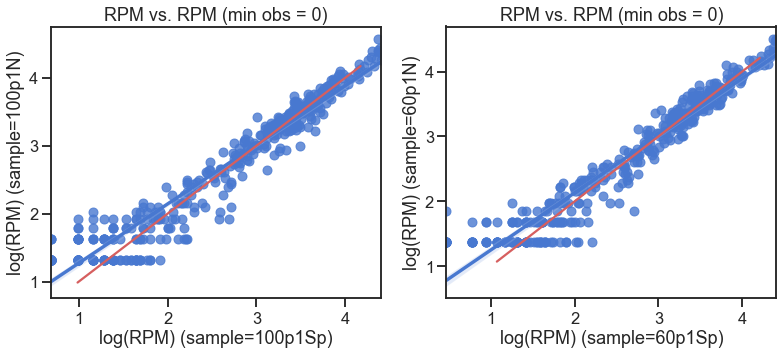

In [326]:
plot_sample_vs_sample(['100p1Sp', '60p1Sp'], ['100p1N', '60p1N'], df_charge, df_charge_melt, min_obs=0, var='logRPM')

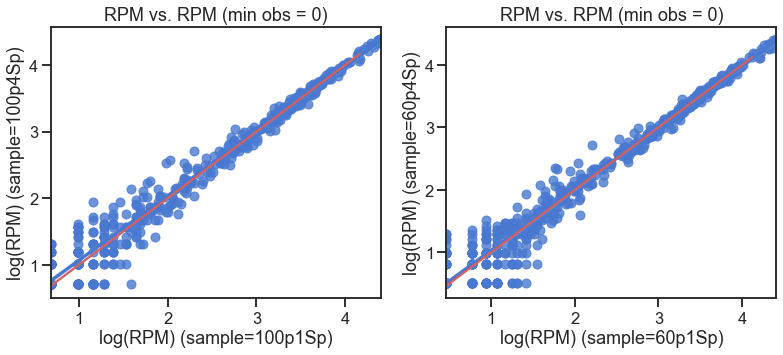

In [327]:
plot_sample_vs_sample(['100p1Sp', '60p1Sp'], ['100p4Sp', '60p4Sp'], df_charge, df_charge_melt, min_obs=0, var='logRPM')

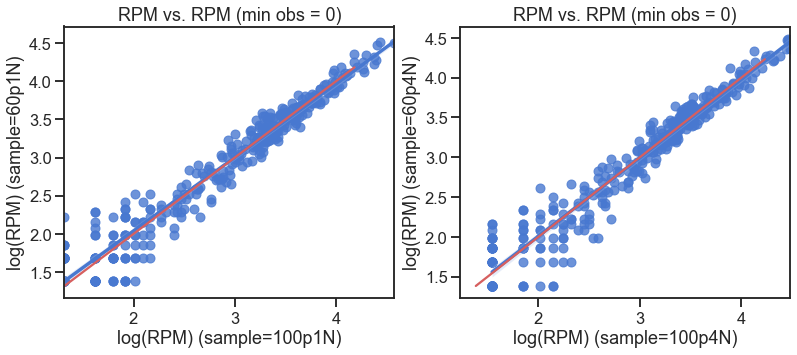

In [328]:
plot_sample_vs_sample(['100p1N', '100p4N'], ['60p1N', '60p4N'], df_charge, df_charge_melt, min_obs=0, var='logRPM')

In [18]:
collections.Counter(df_reads[df_reads['amino_acid'] == 'Pro']['tRNA_annotation'].values).most_common()

[('Homo_sapiens_tRNA-Pro-AGG-2-1@Homo_sapiens_tRNA-Pro-CGG-1-1@Homo_sapiens_tRNA-Pro-TGG-3-1',
  27141),
 ('Homo_sapiens_tRNA-Pro-TGG-3-1', 12458),
 ('Homo_sapiens_tRNA-Pro-CGG-1-1', 9823),
 ('Homo_sapiens_mito_tRNA-Pro-TGG', 7084),
 ('Homo_sapiens_tRNA-Pro-CGG-1-1@Homo_sapiens_tRNA-Pro-TGG-1-1@Homo_sapiens_tRNA-Pro-TGG-3-1',
  5695),
 ('Homo_sapiens_tRNA-Pro-TGG-2-1', 5160),
 ('Homo_sapiens_tRNA-Pro-CGG-2-1', 2550),
 ('Homo_sapiens_tRNA-Pro-TGG-1-1', 1686),
 ('Homo_sapiens_tRNA-Pro-TGG-1-1@Homo_sapiens_tRNA-Pro-TGG-3-1', 1252),
 ('Homo_sapiens_tRNA-Pro-AGG-1-1', 964),
 ('Homo_sapiens_tRNA-Pro-TGG-1-1@Homo_sapiens_tRNA-Pro-TGG-2-1@Homo_sapiens_tRNA-Pro-TGG-3-1',
  935),
 ('Homo_sapiens_tRNA-Pro-AGG-1-1@Homo_sapiens_tRNA-Pro-CGG-1-1', 99),
 ('Homo_sapiens_tRNA-Pro-AGG-1-1@Homo_sapiens_tRNA-Pro-TGG-3-1', 92),
 ('Homo_sapiens_tRNA-Pro-CGG-2-1@Homo_sapiens_tRNA-Pro-TGG-3-1', 58),
 ('Homo_sapiens_tRNA-Pro-CGG-1-1@Homo_sapiens_tRNA-Pro-CGG-2-1@Homo_sapiens_tRNA-Pro-TGG-3-1',
  49),
 ('Homo_s

In [19]:
collections.Counter(df_reads[df_reads['amino_acid'] == 'Pro']['3p_non-temp'].values).most_common()

[('', 73784),
 ('GGC', 248),
 ('A', 102),
 ('CA', 64),
 ('GCA', 63),
 ('GA', 61),
 ('GCC', 52),
 ('AA', 52),
 ('T', 51),
 ('GGCTGCCA', 43),
 ('TA', 42),
 ('G', 42),
 ('C', 41),
 ('GGCT', 36),
 ('GGCTGCC', 31),
 ('TCA', 29),
 ('ACA', 26),
 ('GC', 23),
 ('ACC', 19),
 ('TC', 18),
 ('TCC', 16),
 ('TCTT', 13),
 ('TCATT', 12),
 ('TT', 10),
 ('TAGTT', 9),
 ('CCC', 9),
 ('AC', 9),
 ('ACCA', 9),
 ('TCCTTT', 8),
 ('TCCC', 8),
 ('ACTTCATT', 8),
 ('TCTTT', 7),
 ('AGGCTT', 7),
 ('TGTT', 6),
 ('CCCCC', 6),
 ('CCA', 6),
 ('TCATTT', 5),
 ('TGTTT', 5),
 ('ACTT', 5),
 ('TGTTCCTT', 5),
 ('GGCTT', 5),
 ('GGCTTT', 4),
 ('TCGCTCTTT', 4),
 ('CC', 4),
 ('CCCCCA', 4),
 ('CGCCCCCA', 4),
 ('GGA', 4),
 ('TACCA', 4),
 ('TCCTTTACCTT', 3),
 ('GGTTT', 3),
 ('TCT', 3),
 ('TCCT', 3),
 ('AGGCTTT', 3),
 ('ACTTCATTT', 3),
 ('TCGCTCTT', 3),
 ('CCCCCCA', 3),
 ('ACGACCCCCC', 3),
 ('GGTTTT', 3),
 ('TACTTT', 2),
 ('TAGTTT', 2),
 ('GCTTT', 2),
 ('ACTTT', 2),
 ('TCTTCT', 2),
 ('ACT', 2),
 ('GACC', 2),
 ('AGGCT', 2),
 ('AGCCCCCA'

In [49]:
df_reads.columns

Index(['readID', 'sample_name', 'replicate', 'barcode', 'tRNA_annotation',
       'align_score', 'unique_annotation', 'tRNA_annotation_len',
       'align_5p_idx', 'align_3p_idx', 'align_5p_nt', 'align_3p_nt', 'codon',
       'anticodon', 'amino_acid', '5p_cover', '3p_cover', '5p_non-temp',
       '3p_non-temp', '5p_UMI', '3p_BC', 'mito_codon', 'human_codon',
       'barcode_v2', 'barcode_v3', 'AA_codon'],
      dtype='object')

In [51]:
# Use logomaker to generate position-matrix:
counts_mat_BC = lm.alignment_to_matrix(df_reads['5p_UMI'].values)
counts_mat_BC
# Look at barcode bias in random region:
lm.Logo(counts_mat_BC);

,A,C,G,T
pos,,,,
0,400736.0,286342.0,277924.0,356143.0
1,398870.0,302492.0,258903.0,360880.0
2,410064.0,286925.0,259486.0,364670.0
3,406729.0,297059.0,257152.0,360205.0
4,402391.0,298879.0,255433.0,364442.0
5,401914.0,306050.0,250628.0,362553.0
6,404569.0,291261.0,255977.0,369338.0
7,407244.0,297129.0,259226.0,357546.0
8,407839.0,296501.0,251263.0,365542.0


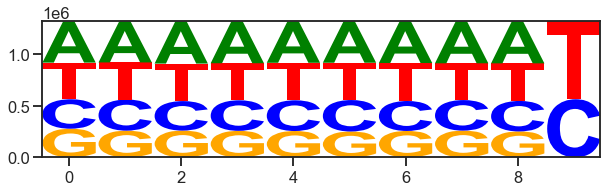

In [7]:
### Make df for codons only
# Collapse and average all anticodon and take the weighted average

In [86]:
### Prepare charge dataframe ###

# Skip header lines, if restarted:
with open('../' + data_dir + '/' + agg_csv_fnam, 'r') as fh:
    skip_list = list()
    for idx, l in enumerate(fh):
        if 'sample_name,replicate,barcode,tRNA_annotation' in l:
            skip_list.append(idx)
skip_list.pop(0)
# Load from csv:
df = pd.read_csv('../' + data_dir + '/' + agg_csv_fnam, skiprows=skip_list)
header_mask = (df['count'] != 'count')
df = df[header_mask]
#df['count'] = [int(v) for v in df['count'].values]
df['mito_codon'] = ['mito_tRNA' in anno for anno in df['tRNA_annotation'].values]
df['human_codon'] = ['Homo_sapiens' in anno for anno in df['tRNA_annotation'].values]
df['AA_codon'] = [AA + '-' + codon for codon, AA in zip(df['codon'].values, df['amino_acid'].values)]
# Add sample sheet information:
df = df.merge(sample_df.loc[:, ['sample_name', 'barcode', 'plot_group', 'hue_name', 'hue_value', 'hue_order']], on=['sample_name', 'barcode'])
# Create single codon filter, to filter out sequences that map to
# tRNA sequences with different codon/anticodon:
single_codon = list()
for anno_str, anticodon in zip(df['tRNA_annotation'].values, df['anticodon'].values):
    sc = True
    anno_list = anno_str.split('@')
    for anno in anno_list:
        if not anno.split('-')[2] == anticodon:
            sc = False
    single_codon.append(sc)
df['single_codon'] = single_codon

# Extract a dataframe for charge data:
dfcol = df.columns.values
col_mask = (dfcol != 'align_3p_nt') & (dfcol != 'count')
cols_sele = dfcol[col_mask]
df_charge = pd.DataFrame(columns=cols_sele)
df_charge['charge'] = []
df_charge['Ncharge'] = []
# Count A/C endings:
df_dict = dict()
for row in df.iterrows():
    key = tuple(row[1].loc[cols_sele])
    if key in df_dict:
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']
    else:
        df_dict[key] = dict()
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']
# Add 0 count if count is missing,
# then calculate the charge percentage:
for key in df_dict.keys():
    if 'A' not in df_dict[key]:
        df_dict[key]['A'] = 0
    if 'C' not in df_dict[key]:
        df_dict[key]['C'] = 0
    
    df_dict[key]['charge'] = df_dict[key]['A'] / (df_dict[key]['A'] + df_dict[key]['C']) * 100
    df_dict[key]['Ncharge'] = (df_dict[key]['A'] + df_dict[key]['C'])

# Use a tmp file to write charge
# and total counts for the row (Ncharge),
# then load into dataframe:
try:
    os.remove('tmp_df.csv')
except:
    pass
with open('tmp_df.csv', 'a') as fh_csv:
    df_charge.to_csv(fh_csv, header=True, index=False)
    for i, key in enumerate(df_dict.keys()):
        row = list(key)
        row.append(df_dict[key]['charge'])
        row.append(df_dict[key]['Ncharge'])
        # df_charge.loc[i] = row # Too slow
        print(','.join(map(str, row)), file=fh_csv)
df_charge = pd.read_csv('tmp_df.csv')
os.remove('tmp_df.csv')

# Generate a normalized charge by using the
# E.coli Lys tRNA spike-in.
# This is supposed to correct some of the barcode ligation bias
# leading to more or less CC vs. CCA:
barcodes = set(df_charge['barcode'].values)
charge_norm = dict()
for barcode in barcodes:
    bar_mask = (df_charge['barcode'] == barcode)
    eColi_mask = (df_charge['amino_acid'] == 'eColiLys')
    eColi_charge = df_charge[bar_mask&eColi_mask]['charge'].values.mean()
    charge_norm[barcode] = eColi_charge
max_charge = max(charge_norm.values())
for barcode in barcodes:
    # Convert to a normalizer for ratio:
    charge_norm[barcode] = freq2ratio(max_charge / 100) / freq2ratio(charge_norm[barcode] / 100)
    # charge_norm[barcode] = (100 - max_charge) / (100 - charge_norm[barcode])
df_charge['charge_norm'] = [0] * len(df_charge)
for barcode in barcodes:
    bar_mask = (df_charge['barcode'] == barcode)
    ratio_sele = freq2ratio(df_charge.loc[bar_mask, 'charge'] / 100)
    df_charge.loc[bar_mask, 'charge_norm'] = ratio2freq(ratio_sele * charge_norm[barcode]) * 100
    # df_charge.loc[bar_mask, 'charge_norm'] = 100 - ((100 - df_charge.loc[bar_mask, 'charge']) * charge_norm[barcode])

<ipython-input-86-48db4ede959d>:91: RuntimeWarning: divide by zero encountered in double_scalars
  charge_norm[barcode] = freq2ratio(max_charge / 100) / freq2ratio(charge_norm[barcode] / 100)


In [55]:
### Per sample charge plots ###

# No normalization
per_sample_plots_dir = 'per_sample_charge'
try:
    os.mkdir(per_sample_plots_dir)
except:
    if CLEAN_DIR:
        shutil.rmtree(per_sample_plots_dir)
        os.mkdir(per_sample_plots_dir)
    else:
        pass

sample_names = set(df_charge['sample_name'].values)
for sample_name in sample_names:

    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge', order=codon_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

    # mito tRNAs
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 20) & (df_charge['single_codon'])
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge', order=codon_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)

    plt.tight_layout()
    fig.savefig('{}/{}.pdf'.format(per_sample_plots_dir, sample_name))
    fig.clear()
    g1.clear()
    g2.clear()

    # Per transcript charge
    fig, ax1 = plt.subplots(1, 1, figsize=(40, 10))
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['unique_annotation'])
    anno_list = sorted(set(df_charge['tRNA_annotation'][mask].values), key=str.casefold)
    # Make color cycle for same codons:
    anno2codon = {a: c for a, c in zip(df_charge['tRNA_annotation'][mask].values, df_charge['AA_codon'][mask].values)}
    cmap = sns.color_palette(None, len(anno_list))
    codons = sorted(set(df_charge[mask]['AA_codon'].values), key=str.casefold)
    codon2color = {nam: cmap[i] for i, nam in enumerate(codons)}
    palette = {a: codon2color[anno2codon[a]] for a in df_charge['tRNA_annotation'][mask].values}
    g1 = sns.barplot(ax=ax1, x='tRNA_annotation', y='charge', palette=palette, order=anno_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    plt.tight_layout()
    fig.savefig('{}/transcripts_{}.pdf'.format(per_sample_plots_dir, sample_name))
    fig.clear()
    g1.clear()
    
#### Barcode bias ####
fig = plt.figure(figsize=(40, 9))
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 1:3])

# Cyto tRNAs
mask = (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
codon_list.pop(codon_list.index('eColiLys-AAA'))
codon_list = ['eColiLys-AAA'] + codon_list
g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge', order=codon_list, hue_order=['l1', 'l2', 'l3', 'l4'], hue='barcode', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['l1', 'l2', 'l3', 'l4']
title = 'Barcode'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)

# mito tRNAs
mask = (df_charge['mito_codon']) & (df_charge['Ncharge'] > 20) & (df_charge['single_codon'])
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge', order=codon_list, hue_order=['l1', 'l2', 'l3', 'l4'], hue='barcode', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g2.set_title('Mitochondrial tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('Charge (%)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['l1', 'l2', 'l3', 'l4']
title = 'Barcode'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.tight_layout()
fig.savefig('{}/barcode-bias_codon-breakdown.pdf'.format(per_sample_plots_dir))
fig.clear()
g1.clear()
g2.clear()

# All tRNAs
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
g1 = sns.barplot(ax=ax1, x='barcode', y='charge', order=['l1', 'l2', 'l3', 'l4'], data=df_charge, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('All tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
plt.tight_layout()
fig.savefig('{}/barcode-bias_all-tRNAs.pdf'.format(per_sample_plots_dir))
fig.clear()
g1.clear()





# Normalized by E.coli Lys spike-in
per_sample_plots_dir = 'per_sample_charge_norm'
try:
    os.mkdir(per_sample_plots_dir)
except:
    if CLEAN_DIR:
        shutil.rmtree(per_sample_plots_dir)
        os.mkdir(per_sample_plots_dir)
    else:
        pass

sample_names = set(df_charge['sample_name'].values)
for sample_name in sample_names:

    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge_norm', order=codon_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

    # mito tRNAs
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 20) & (df_charge['single_codon'])
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge_norm', order=codon_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)

    plt.tight_layout()
    fig.savefig('{}/{}.pdf'.format(per_sample_plots_dir, sample_name))
    fig.clear()
    g1.clear()
    g2.clear()

    # Per transcript charge
    fig, ax1 = plt.subplots(1, 1, figsize=(40, 10))
    mask = (df_charge['sample_name'] == sample_name) & (df_charge['human_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['unique_annotation'])
    anno_list = sorted(set(df_charge['tRNA_annotation'][mask].values), key=str.casefold)
    # Make color cycle for same codons:
    anno2codon = {a: c for a, c in zip(df_charge['tRNA_annotation'][mask].values, df_charge['AA_codon'][mask].values)}
    cmap = sns.color_palette(None, len(anno_list))
    codons = sorted(set(df_charge[mask]['AA_codon'].values), key=str.casefold)
    codon2color = {nam: cmap[i] for i, nam in enumerate(codons)}
    palette = {a: codon2color[anno2codon[a]] for a in df_charge['tRNA_annotation'][mask].values}
    g1 = sns.barplot(ax=ax1, x='tRNA_annotation', y='charge_norm', palette=palette, order=anno_list, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    plt.tight_layout()
    fig.savefig('{}/transcripts_{}.pdf'.format(per_sample_plots_dir, sample_name))
    fig.clear()
    g1.clear()
    

#### Barcode bias ####
fig = plt.figure(figsize=(40, 9))
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 1:3])

# Cyto tRNAs
mask = (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
codon_list.pop(codon_list.index('eColiLys-AAA'))
codon_list = ['eColiLys-AAA'] + codon_list
g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge_norm', order=codon_list, hue_order=['l1', 'l2', 'l3', 'l4'], hue='barcode', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['l1', 'l2', 'l3', 'l4']
title = 'Barcode'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)

# mito tRNAs
mask = (df_charge['mito_codon']) & (df_charge['Ncharge'] > 20) & (df_charge['single_codon'])
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge_norm', order=codon_list, hue_order=['l1', 'l2', 'l3', 'l4'], hue='barcode', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g2.set_title('Mitochondrial tRNA')
g2.grid(True, axis='y')
g2.set_ylabel('Charge (%)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['l1', 'l2', 'l3', 'l4']
title = 'Barcode'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.tight_layout()
fig.savefig('{}/barcode-bias_codon-breakdown.pdf'.format(per_sample_plots_dir))
fig.clear()
g1.clear()
g2.clear()

# All tRNAs
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
g1 = sns.barplot(ax=ax1, x='barcode', y='charge_norm', order=['l1', 'l2', 'l3', 'l4'], data=df_charge, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('All tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
plt.tight_layout()
fig.savefig('{}/barcode-bias_all-tRNAs.pdf'.format(per_sample_plots_dir))
fig.clear()
g1.clear()
plt.close(fig)

<ipython-input-55-5457f4197b35>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20, 9))


<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x648 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 1440x648 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x648 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
g1 = sns.barplot(ax=ax1, x='barcode', y='charge', order=['l1', 'l2', 'l3', 'l4', 'l1N', 'l2N', 'l3N', 'l4N'], data=df_charge, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('All tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
plt.tight_layout()

In [ ]:
df_charge

In [57]:
### Per group charge plots ###

# No normalization
per_group_plots_dir = 'per_group_charge'
try:
    os.mkdir(per_group_plots_dir)
except:
    if CLEAN_DIR:
        shutil.rmtree(per_group_plots_dir)
        os.mkdir(per_group_plots_dir)
    else:
        pass

plot_groups = set(df_charge['plot_group'].values)
for plot_group in plot_groups:
    Ngrp = len(set(df_charge[(df_charge['plot_group'] == plot_group)]['hue_order'].values))

    fig = plt.figure(figsize=(28/3*Ngrp, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    #mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 100) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 30) & (df_charge['single_codon'])
    if sum(mask) == 0:
        continue
    hue_order = [t[0] for t in sorted(dict(zip(df_charge[mask]['hue_value'].values, df_charge[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
    
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    old_legend = g1.legend_
    handles = old_legend.legendHandles
    labels = hue_order
    title = df_charge[mask]['hue_name'].values[0]
    g1.legend(handles, labels, title=title, bbox_to_anchor=(1.01,1), borderaxespad=0)
 
    # mito tRNAs
    # mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 30) & (df_charge['single_codon'])
    if sum(mask) == 0:
        continue
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
    g2.legend_.remove()

    plt.tight_layout()
    fig.savefig('{}/{}.pdf'.format(per_group_plots_dir, plot_group))
    fig.clear()
    g1.clear()
    g2.clear()





    



<Figure size 1344x648 with 0 Axes>

<Figure size 2016x648 with 0 Axes>

<Figure size 1344x648 with 0 Axes>

<Figure size 2688x648 with 0 Axes>

In [14]:
plot_group

'barcode_v2'

In [16]:
mask = (df_charge['plot_group'] == plot_group) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 100) & (df_charge['single_codon'])
df_charge[mask].to_csv('qwerty.csv')

In [ ]:
# Normalized by E.coli Lys spike-in
per_group_plots_dir = 'per_group_charge_norm'
try:
    os.mkdir(per_group_plots_dir)
except:
    if CLEAN_DIR:
        shutil.rmtree(per_group_plots_dir)
        os.mkdir(per_group_plots_dir)
    else:
        pass

plot_groups = set(df_charge['plot_group'].values)
for plot_group in plot_groups:
    Ngrp = len(set(df_charge[(df_charge['plot_group'] == plot_group)]['hue_order'].values))

    fig = plt.figure(figsize=(28/3*Ngrp, 9))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 1:3])

    # Cyto tRNAs
    #mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    if sum(mask) == 0:
        continue
    hue_order = [t[0] for t in sorted(dict(zip(df_charge[mask]['hue_value'].values, df_charge[mask]['hue_order'].values)).items(), key=lambda x: x[1])]
    
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge_norm', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g1.set_title('Cytoplasmic tRNA')
    g1.grid(True, axis='y')
    g1.set_ylabel('Charge (%)');
    g1.set_xlabel('');
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    old_legend = g1.legend_
    handles = old_legend.legendHandles
    labels = hue_order
    title = df_charge[mask]['hue_name'].values[0]
    g1.legend(handles, labels, title=title, bbox_to_anchor=(1.01,1), borderaxespad=0)
 
    # mito tRNAs
    #mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    mask = (df_charge['plot_group'] == plot_group) & (df_charge['mito_codon']) & (df_charge['Ncharge'] > 50) & (df_charge['single_codon'])
    if sum(mask) == 0:
        continue
    codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
    g2 = sns.barplot(ax=ax2, x='AA_codon', y='charge_norm', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
    g2.set_title('Mitochondrial tRNA')
    g2.grid(True, axis='y')
    g2.set_ylabel('Charge (%)');
    g2.set_xlabel('');
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
    g2.legend_.remove()

    plt.tight_layout()
    fig.savefig('{}/{}.pdf'.format(per_group_plots_dir, plot_group))
    fig.clear()
    g1.clear()
    g2.clear()

In [10]:
### Plot histogram of non-template addition length

In [9]:
### 5' non-template bases logo plot ###
min_obs = 5000

_5p_plots_dir = '5p_non-template'
try:
    os.mkdir(_5p_plots_dir)
    os.mkdir(_5p_plots_dir + '/count')
    os.mkdir(_5p_plots_dir + '/frequency')
except:
    if CLEAN_DIR:
        shutil.rmtree(_5p_plots_dir)
        os.mkdir(_5p_plots_dir)
        os.mkdir(_5p_plots_dir + '/count')
        os.mkdir(_5p_plots_dir + '/frequency')
    else:
        pass

_5p_dict = dict()
with bz2.open('../' + data_dir + '/' + stat_csv_fnam, 'rt') as csv_fh:
    reader = csv.reader(csv_fh)
    header = next(reader)
    for row in reader:
        _5p_cover, _3p_cover, _5p_non_temp, _3p_non_temp = row[-4:]
        align_5p_nt = row[10]
        if _3p_cover == 'True' and _3p_non_temp == '' and _5p_non_temp != '':
            for pos, base in enumerate(_5p_non_temp):
                key = (pos, align_5p_nt, eval(_5p_cover), base)
                if key in _5p_dict:
                    _5p_dict[key] += 1
                else:
                    _5p_dict[key] = 1

with open('tmp_df.csv', 'w') as fh_csv:
    print('position,pre_nt,5p_covered,base,count', file=fh_csv)
    for key in _5p_dict:
        print('{},{}'.format(','.join(map(str, key)), _5p_dict[key]), file=fh_csv)
_5p_df = pd.read_csv('tmp_df.csv')


# Make logo plots:
for pre_base in ['A', 'T', 'G', 'C', 'N']:
    if pre_base != 'N':
        mask_pre_base = _5p_df['pre_nt'] == pre_base
    else:
        mask_pre_base = np.array([True]*len(_5p_df))
    for _5pc in [True, False, 'all']:
        if _5pc is True:
            mask_5p_cover = mask_pre_base & (_5p_df['5p_covered'])
            mask_name = 'pre_base-{}_5p-covered'.format(pre_base)
        elif _5pc is False:
            mask_5p_cover = mask_pre_base & (~_5p_df['5p_covered'])
            mask_name = 'pre_base-{}_5p-uncovered'.format(pre_base)
        elif _5pc == 'all':
            mask_5p_cover = mask_pre_base & np.array([True]*len(_5p_df))
            mask_name = 'pre_base-{}_5p-all'.format(pre_base)

        plot_df = _5p_df[mask_5p_cover]
        plot_df = plot_df.pivot_table(index='position', columns=['base'], values=['count'], aggfunc=np.sum)
        plot_df.columns = [c[1] for c in plot_df.columns]
        plot_df['total'] = plot_df['A'].values + plot_df['C'].values + plot_df['G'].values + plot_df['T'].values
        obs_mask = plot_df['total'] > min_obs
        plot_df = plot_df[obs_mask]
        plot_df_count = plot_df.drop(columns=['total'])
        plot_df_freq = plot_df.copy()
        plot_df_freq['A'] = plot_df_freq['A'].values / plot_df_freq['total'].values
        plot_df_freq['T'] = plot_df_freq['T'].values / plot_df_freq['total'].values
        plot_df_freq['C'] = plot_df_freq['C'].values / plot_df_freq['total'].values
        plot_df_freq['G'] = plot_df_freq['G'].values / plot_df_freq['total'].values
        plot_df_freq = plot_df_freq.drop(columns=['total'])
        plot_df_count.index = plot_df.index.values[::-1]
        plot_df_freq.index = plot_df.index.values[::-1]

        # Count based logo:
        if len(plot_df) > 4:
            fig, ax = plt.subplots(1,1, figsize=[len(plot_df), 3.5])
        else:
            fig, ax = plt.subplots(1,1, figsize=[4, 3.5])
        _5p_logo_count = lm.Logo(plot_df_count,
                                  ax=ax,
                                  shade_below=.5,
                                  fade_below=.5,
                                  font_name='Arial Rounded MT Bold')
        _5p_logo_count.ax.set_ylabel('Observations', labelpad=0)
        _5p_logo_count.ax.set_title(mask_name)
        _5p_logo_count.fig.tight_layout()
        _5p_logo_count.fig.savefig('{}/count/{}.pdf'.format(_5p_plots_dir, mask_name))
        _5p_logo_count.fig.clear()

        # Frequency based logo:
        if len(plot_df) > 4:
            fig, ax = plt.subplots(1,1, figsize=[len(plot_df), 3.5])
        else:
            fig, ax = plt.subplots(1,1, figsize=[4, 3.5])
        _5p_logo_freq = lm.Logo(plot_df_freq,
                                  ax=ax,
                                  shade_below=.5,
                                  fade_below=.5,
                                  font_name='Arial Rounded MT Bold')
        _5p_logo_freq.ax.set_ylabel('Observations', labelpad=0)
        _5p_logo_freq.ax.set_title(mask_name)
        _5p_logo_freq.fig.tight_layout()
        _5p_logo_freq.fig.savefig('{}/frequency/{}.pdf'.format(_5p_plots_dir, mask_name))
        _5p_logo_freq.fig.clear()


KeyboardInterrupt: 

In [87]:
set(df_charge['plot_group'].values)

{'barcode_v2', 'barcode_v3', 'deacylation_high_pH', 'deacylation_low_pH'}

In [107]:
# No normalization
per_group_plots_dir = 'per_group_charge'

plot_group = 'deacylation_low_pH'

Ngrp = len(set(df_charge[(df_charge['plot_group'] == plot_group)]['hue_order'].values))

fig, ax = plt.subplots(1, 1, figsize=[20, 5])

# Cyto tRNAs
#mask = (df_charge['plot_group'] == plot_group) & (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 100) & (df_charge['single_codon'])
codon_set = {cd for sn, cd in zip(df_charge[mask]['sample_name'], df_charge[mask]['codon']) if sn == 'L5'}
df_charge['codon'].isin(codon_set)
mask = (df_charge['plot_group'] == plot_group) & (~df_charge['mito_codon']) & (df_charge['Ncharge'] > 30) & (df_charge['single_codon'])
codon_set = {cd for sn, cd in zip(df_charge[mask]['sample_name'], df_charge[mask]['codon']) if sn == 'L5'}
mask = mask & df_charge['codon'].isin(codon_set)

hue_order = [t[0] for t in sorted(dict(zip(df_charge[mask]['hue_value'].values, df_charge[mask]['hue_order'].values)).items(), key=lambda x: x[1])]

codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)
g1 = sns.barplot(ax=ax, x='AA_codon', y='charge', order=codon_list, hue='hue_value', hue_order=hue_order, data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.set_title('Cytoplasmic tRNA')
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
old_legend = g1.legend_
handles = old_legend.legendHandles
labels = hue_order
title = 'Deacylation time'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.01,1), borderaxespad=0)

plt.tight_layout()
fig.savefig('{}/{}.pdf'.format(per_group_plots_dir, plot_group+'_noMito'))
fig.clear()
g1.clear()



<Figure size 1440x360 with 0 Axes>

In [123]:
df_charge

,sample_name,replicate,barcode,tRNA_annotation,tRNA_annotation_len,unique_annotation,codon,anticodon,amino_acid,mito_codon,human_codon,AA_codon,single_codon,charge,Ncharge,charge_norm
0,Rich,1,l1,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,AAA,TTT,eColiLys,False,False,eColiLys-AAA,True,45.226131,199,55.701367
1,Rich,1,l1,Homo_sapiens_mito_tRNA-Ala-TGC-1-1,72,True,GCA,TGC,Ala,True,True,Ala-GCA,True,70.731707,41,87.114523
2,Rich,1,l1,Homo_sapiens_mito_tRNA-Arg-TCG-1-1,68,True,CGA,TCG,Arg,True,True,Arg-CGA,True,64.444444,45,79.371010
3,Rich,1,l1,Homo_sapiens_mito_tRNA-Asn-GTT-1-1,76,True,AAC,GTT,Asn,True,True,Asn-AAC,True,56.250000,32,69.278576
4,Rich,1,l1,Homo_sapiens_mito_tRNA-Asp-GTC-1-1,71,True,GAC,GTC,Asp,True,True,Asp-GAC,True,72.093023,86,88.791146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6347,A-NaCl,1,l4,Homo_sapiens_tRNA-Val-TAC-3-1,76,True,GUA,TAC,Val,False,True,Val-GUA,True,98.181818,55,98.181818
6348,A-NaCl,1,l4,Homo_sapiens_tRNA-Val-TAC-4-1,76,True,GUA,TAC,Val,False,True,Val-GUA,True,100.000000,18,100.000000
6349,A-NaCl,1,l4,Homo_sapiens_tRNA-iMet-CAT-1-1,75,True,AUG,CAT,iMet,False,True,iMet-AUG,True,99.598930,2244,99.598930
6350,A-NaCl,1,l4,Homo_sapiens_tRNA-iMet-CAT-1-1@Homo_sapiens_tR...,75,False,AUG,CAT,iMet,False,True,iMet-AUG,True,100.000000,8,100.000000


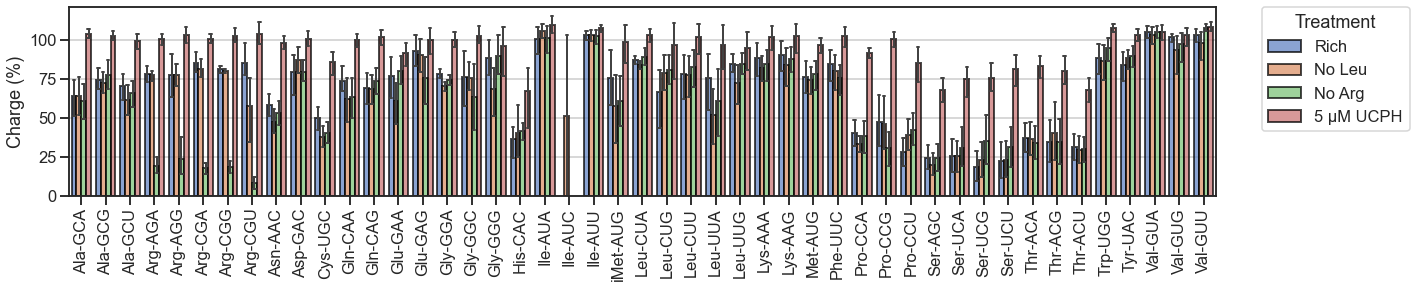

In [58]:
mask = (df_charge['human_codon']) & (~df_charge['mito_codon']) & (df_charge['barcode'] != 'l4')
codon_list = sorted(set(df_charge['AA_codon'][mask].values), key=str.casefold)

fig, ax1 = plt.subplots(1, 1, figsize=(20, 4.4))

g1 = sns.barplot(ax=ax1, x='AA_codon', y='charge_norm', hue='sample_name', order=codon_list, hue_order=['Rich', 'L', 'A', 'U'], data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['Rich', 'No Leu', 'No Arg', '5 μM UCPH']
title = 'Treatment'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)


plt.tight_layout()
fig.savefig('mito.pdf')